In [29]:
import numpy as np
import pandas as pd

# Financial Data Sources
import yfinance as yf
import pandas_datareader as pdr
import eurostat as estat

# Data visualisation
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import date

# Question 1

In [2]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 4; day=24
Period for indexes: 1954-04-24 to 2024-04-24 


In [3]:
# Download GDPC1 from FRED (https://fred.stlouisfed.org/series/GDPC1)
gdpc1 = pdr.DataReader("GDPC1", "fred", start=start)

In [46]:
# Calculate YoY
gdpc1['gdpc1_yoy'] = (gdpc1.GDPC1/gdpc1.GDPC1.shift(4)-1)
yoy = gdpc1['gdpc1_yoy'].tail(4).mean()
print('The average growth rate of GDP in 2023 was {:.1%}'.format(yoy))

The average growth rate of GDP in 2023 was 2.5%


# Question 2

In [4]:
# Download DGS2 and DGS10 from FRED (https://fred.stlouisfed.org/series/DGS2, https://fred.stlouisfed.org/series/DGS10)
dgs2 = pdr.DataReader("DGS2", "fred", start=start)
dgs10 = pdr.DataReader("DGS10", "fred", start=start)

In [5]:
# Join the dataframes
dgs2_10 = dgs2.join(dgs10, on='DATE', how='left')

In [6]:
dgs2_10['diff'] = dgs2_10['DGS10'] - dgs2_10['DGS2']
inv_treasury_yield = dgs2_10.loc['20000101':]['diff'].min()
print('The min value of (dgs10 - dgs2) since 2020 is {:.1f}'.format(inv_treasury_yield))

The min value of (dgs10 - dgs2) since 2020 is -1.1


An inverted yield cruve means that shorter-term interest rates are higher than long-term rates. It is seen as an indicator that the markes is in trouble and considered to be a predictor of an economic recession, as historically it has often preceded economic recessions. I think for investors it is a warning sign as it point to market volatility and results in investor making more cuatios investments such as bonds.

In [43]:
# Download  from Eurostat (https://ec.europa.eu/eurostat/web/main/data/database)
my_filter_pars = {'startPeriod': 2020, 'geo':'NL'}
data = estat.get_data('irt_h_cgby_a', filter_pars=my_filter_pars)
#couldn't quite figure this out yet, will keep trying over the next week

faultcode: 150
faultstring: INVALID_QUERY_DIMENSION_VALUE: Query is invalid as per its structure's definition. The following values for dimension are not allowed: TIME_PERIOD: >=2020-01-01.


HTTPError: 400 Client Error: Bad Request for url: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/irt_h_cgby_a/..NL?startPeriod=2020&format=TSV&compressed=true

# Question 3

In [7]:
data_sp = yf.download('^GSPC','2019-04-09','2024-04-09')

[*********************100%%**********************]  1 of 1 completed


In [8]:
data_ipc = yf.download('^MXX','2019-04-09','2024-04-09')

[*********************100%%**********************]  1 of 1 completed


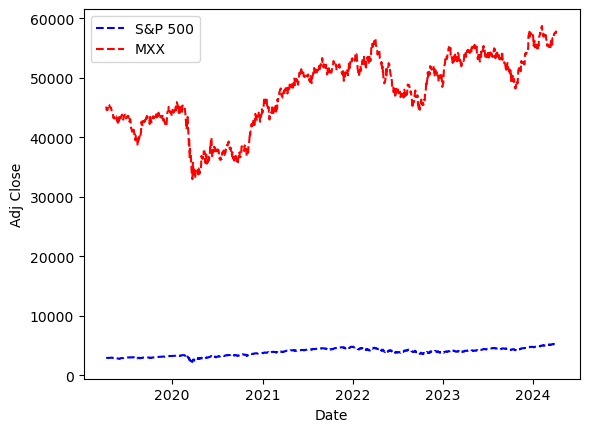

In [9]:
# Plot the close price of the GDPC and MXX
# Plotting the first line
plt.plot(data_sp.index, data_sp['Adj Close'], label='S&P 500', color='blue', linestyle='--')

# Plotting the second line
plt.plot(data_ipc.index, data_ipc['Adj Close'], label='MXX', color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Adj Close')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


In [57]:
# Calcualte 5 year growth
# Create an empty dictionary to store the growth ratios for each index
sp_ratio = data_sp.iloc[-1]['Adj Close']/data_sp.iloc[0]['Adj Close']
print(sp_ratio)
mxx_ratio = (data_ipc.iloc[-1]['Adj Close']/data_ipc.iloc[0]['Adj Close'])
print(mxx_ratio)
highest_growth = max(sp_ratio, mxx_ratio)
print(highest_growth)

1.8075151917783085
1.2843377484045295
1.8075151917783085


In [60]:
# Calculate the growth percentage (closest integer %)
growth_percentage = round((highest_growth - 1) * 100, 0)
print(growth_percentage)

81.0


The higher growing index over the last 5 years is S&P 500 in comparison to IPC Mexico, it has grown by 181%.

# Question 4

In [61]:
tickers_list = ['2222.SR', 'BRK-B', 'AAPL', 'MSFT', 'GOOG', 'JPM']
data = yf.download(tickers_list,'2023-01-01','2023-12-31')

[*********************100%%**********************]  6 of 6 completed


In [17]:
range_ratios = (data['Adj Close'].max() - data['Adj Close'].min()) / data['Adj Close'].max()
print('The largest range ratio is {:.2f} from the stock {}.'.format(range_ratios.max(), range_ratios.idxmax(axis='index')))

The largest range ratio is 0.42 from the stock MSFT.


The range ratio could be important for my research into stocks because it gives you information on the volatility of the stock over a 52-week period. So I would think tha stocks with higher values are riskier because their price variability is greater.

# Question 5

In [70]:
# Divident yield calculation for each stock
tickers_list = ['2222.SR', 'BRK-B', 'AAPL', 'MSFT', 'GOOG', 'JPM']
data = yf.download(tickers_list,'2023-01-01','2023-12-31')

# Make a dataframe that has the different tickers as column names to later store the dividend yields in
df_div = pd.DataFrame(index=['2023'], columns=tickers_list)

# Store the sums of the dividens for 2023 for each stock in the list sums
sums = []
for i in tickers_list:
    sums.append(yf.Ticker(i).dividends.sum())

for i in range(0, len(tickers_list)):
    # Check if there is a value for the last adj close of the year, if there isn't select the previous one (case for BRK-B)
    if np.isnan(data['Adj Close'][tickers_list[i]].iloc[-1]):
    # If NaN values are present, access the previous row
        previous_row = data['Adj Close'][tickers_list[i]].iloc[-2]
        print("Last row contains NaN values. Accessing previous row:")
        print(previous_row)
        last_close = previous_row
    else:
        # If no NaN values are present, print the last row
        print("Last row does not contain NaN values:")
        print(data['Adj Close'][tickers_list[i]].iloc[-1])
        last_close = data['Adj Close'][tickers_list[i]].iloc[-1]

    # Calculate the dividen yield for each stock and round to 1 decimal
    df_div[tickers_list[i]] = round((sums[i]/ last_close) * 100, 1)

print('The maximum dividend yield out of the 6 stocks is {} from {}'.format(df_div.max(axis=1).iloc[0], df_div.idxmax(axis='columns').iloc[0]))


[*********************100%%**********************]  6 of 6 completed


Last row contains NaN values. Accessing previous row:
32.87778854370117
Last row does not contain NaN values:
356.6600036621094
Last row does not contain NaN values:
192.28463745117188
Last row does not contain NaN values:
375.34588623046875
Last row does not contain NaN values:
140.92999267578125
Last row does not contain NaN values:
168.07711791992188
The maximum dividend yield out of the 6 stocks is 34.8 from JPM


In [64]:
print('The maximum dividend yield out of the 6 stocks is {} from {}'.format(df_div.max(axis=1).iloc[0], df_div.idxmax(axis='columns').iloc[0]))
# There does not seem to be dividend data for BRK-B and GOOG which doesn't seem right, but I couldn't figure out what was going on there

The maximum dividend yield out of the 6 stocks is 34.8 from JPM


Looking at the results options I clearly did something wrong here.

# Question 6

# Environmetal earning reports from 
How does the performance of the 5 biggest ESG ETF funds according to (https://www.insidermonkey.com/blog/5-best-esg-etfs-1194400/) compare to the performance of S&P500 over the last 10 years?

Make time series plot of adj close for the last 5 years,
bar plot comparing amount of holdings in each?


In [34]:
# Download data suing tickers from yahoo finance
esg_etf_tickers = ['SUSA', 'DSI', 'SNPE', 'SUSL', 'USSG', 'SPXS.L']
df = yf.download(esg_etf_tickers, start='2018-01-01', end='2023-12-31', interval='1d')['Adj Close']


[*********************100%%**********************]  6 of 6 completed


c:\Users\mmo990\AppData\Local\anaconda3\envs\investpythonzoomcamp\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mmo990\AppData\Local\anaconda3\envs\investpythonzoomcamp\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


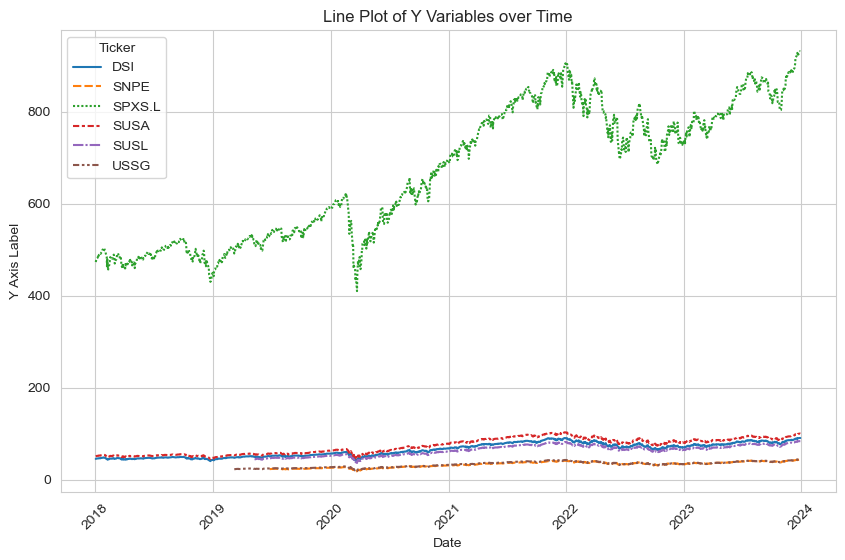

In [35]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the line plot using seaborn
sns.lineplot(data=df)

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Adjusted clsoing price')
plt.title('Line Plot of Y Variables over Time')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

My ideas was to explore ESG ratings data from yahoo finance but I couldn't figure out how to download the data, it seems that the yfinance library used to have a sustainability option but not anymore. I thought I would compare ETF funds, clearly the one that tracks S&P500 (SPXS.L) had hihger closing prices. Running out of time today (bad time management on my side) but I think Iwill try to scrap some data over the weekend (the Selenium script to scrao data from jsutetf on pythoninvest looks like a great guideline, so thanks!).

# Question 6

On thing I would look at is historical perfromance, so historically when a companu did its earning announcements what happened to its stock rpice and trading volume? Has it more often over or under performed? What was the volatility of their stock prices historically around earning announcements? And then looking ahead I think I would try and get information on things such as earning growht potential, revenue forecasts.